<a href="https://colab.research.google.com/github/abelnane/Spotify_Analisis/blob/main/K_means_clustering_model_SuperMarketDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
saurabhbadole_supermarket_data_path = kagglehub.dataset_download('saurabhbadole/supermarket-data')

print('Data source import complete.')


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importar librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Cargamos el conjunto de datos y exploramos su contenido



In [3]:
df = pd.read_csv('/content/drive/MyDrive/nuevo_supermarket_test_2025_practicing/supermarket_data.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541910, 8)

### Verificamos los valores nulos

In [5]:
missing_values = df.isnull().sum()

# Verificar valores duplicados
duplicate_rows = df.duplicated().sum()

# Revisar valores negativos en cantidad y precio
negative_values = (df["Quantity"] < 0).sum(), (df["Price"] < 0).sum()

# Mostrar resultados
missing_values, duplicate_rows, negative_values

(Invoice             0
 StockCode           0
 Description      1454
 Quantity            0
 InvoiceDate         0
 Price               0
 Customer ID    135080
 Country             0
 dtype: int64,
 5268,
 (10624, 2))

### Eliminar filas con Customer ID nulo (necesario para segmentación)

In [6]:
df_clean = df.dropna(subset=["Customer ID"])

# Eliminar filas duplicadas
df_clean = df_clean.drop_duplicates()

# Eliminar valores negativos en cantidad y precio
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["Price"] > 0)]

# Verificar nuevamente la limpieza
missing_values_after = df_clean.isnull().sum()
duplicate_rows_after = df_clean.duplicated().sum()
negative_values_after = (df_clean["Quantity"] < 0).sum(), (df_clean["Price"] < 0).sum()

missing_values_after, duplicate_rows_after, negative_values_after

(Invoice        0
 StockCode      0
 Description    0
 Quantity       0
 InvoiceDate    0
 Price          0
 Customer ID    0
 Country        0
 dtype: int64,
 0,
 (0, 0))

### importamos librerías para nuestro modelo

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Convertimos InvoiceDate a tipo DateTime y procedemos a realizar el modelo junto con las visualizaciones



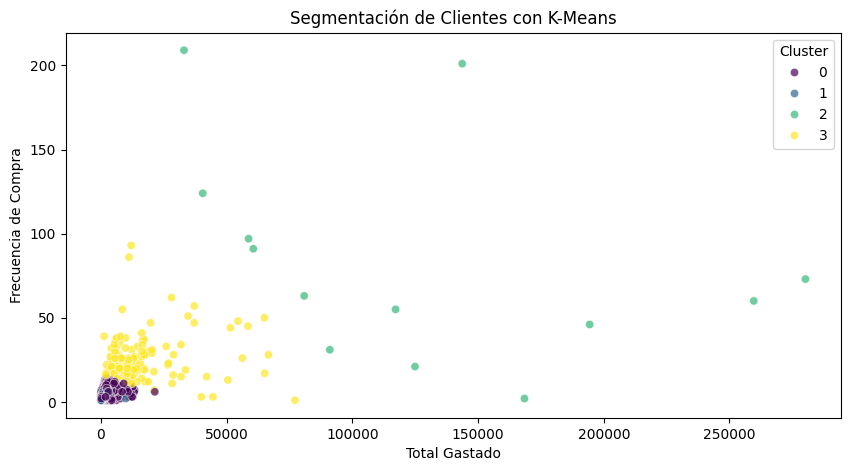

In [8]:
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], format="%d/%m/%y %H:%M")

# Crear columna de ingresos totales por transacción
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

# Crear dataset de segmentación
customer_grouped = df_clean.groupby("Customer ID").agg(
    TotalSpent=("TotalPrice", "sum"),     # Total gastado
    Frequency=("Invoice", "nunique"),     # Número de compras únicas
    Recency=("InvoiceDate", lambda x: (df_clean["InvoiceDate"].max() - x.max()).days)  # Días desde última compra
).reset_index()

# Estandarizar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_grouped[["TotalSpent", "Frequency", "Recency"]])

# Aplicar K-Means con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_grouped["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualizar la distribución de los clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x=customer_grouped["TotalSpent"], y=customer_grouped["Frequency"],
                hue=customer_grouped["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("Total Gastado")
plt.ylabel("Frecuencia de Compra")
plt.title("Segmentación de Clientes con K-Means")
plt.legend(title="Cluster")
plt.show()

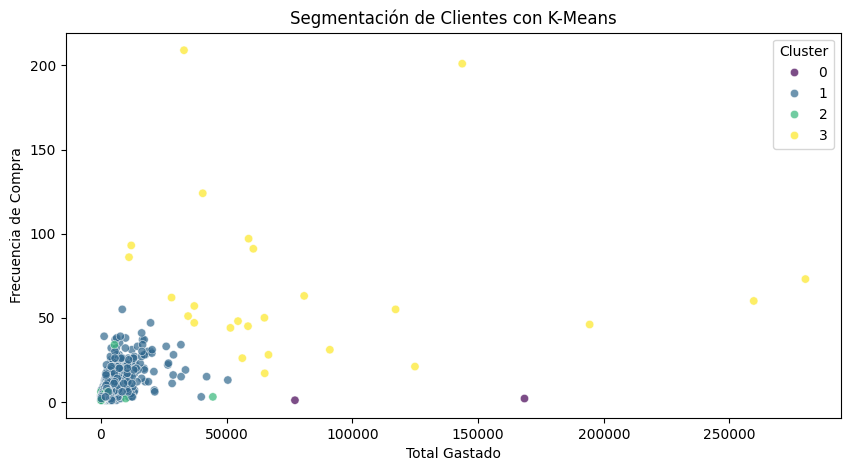

In [9]:
customer_grouped["AvgSpentPerPurchase"] = customer_grouped["TotalSpent"] / customer_grouped["Frequency"]

# Estandarizar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_grouped[["TotalSpent", "Frequency", "Recency", "AvgSpentPerPurchase"]])

# Aplicar K-Means con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_grouped["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualizar la distribución de los clusters (TotalSpent vs. Frequency)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=customer_grouped["TotalSpent"], y=customer_grouped["Frequency"],
                hue=customer_grouped["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("Total Gastado")
plt.ylabel("Frecuencia de Compra")
plt.title("Segmentación de Clientes con K-Means")
plt.legend(title="Cluster")
plt.show()

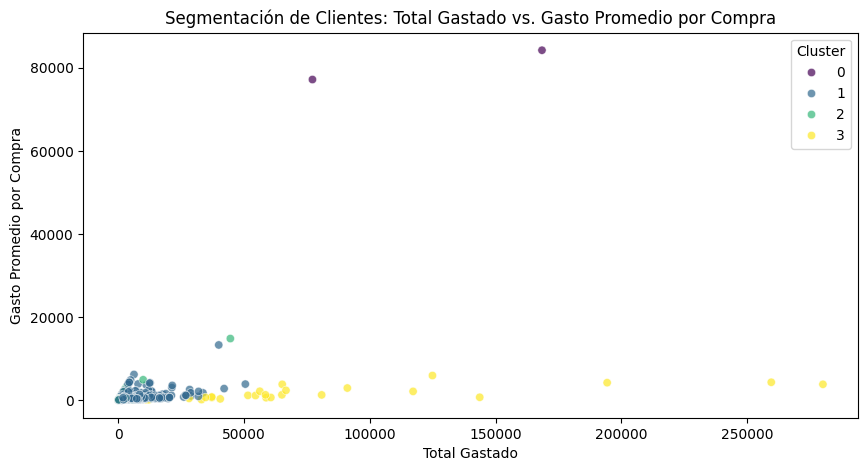

In [10]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=customer_grouped["TotalSpent"], y=customer_grouped["AvgSpentPerPurchase"],
                hue=customer_grouped["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("Total Gastado")
plt.ylabel("Gasto Promedio por Compra")
plt.title("Segmentación de Clientes: Total Gastado vs. Gasto Promedio por Compra")
plt.legend(title="Cluster")
plt.show()

In [11]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Desescalar valores
centroids_df = pd.DataFrame(centroids, columns=["TotalSpent", "Frequency", "Recency", "AvgSpentPerPurchase"])

# Agregar número de cluster
centroids_df["Cluster"] = range(4)

print("Centroides de los Clusters:")
print(centroids_df)

Centroides de los Clusters:
      TotalSpent  Frequency     Recency  AvgSpentPerPurchase  Cluster
0  122828.050000   1.500000  162.500000         80709.925000        0
1    1861.457522   4.672238   40.497679           388.395359        1
2     522.403714   1.581481  246.093519           326.056824        2
3   82520.221200  69.000000    5.240000          1731.402973        3


### Análisis de los Clusters:

Cluster 0 - Clientes Ocasionales
Bajo TotalSpent, baja Frecuencia, alta Recency
Compran muy poco y su última compra fue hace mucho tiempo.
Estrategia: Incentivar con descuentos y promociones para que regresen.

Cluster 1 - Clientes Regulares
Moderado TotalSpent, moderada Frecuencia, media Recency
Compran de manera estable, pero sin gastar grandes montos.
Estrategia: Ofrecer programas de fidelización o recompensas.

Cluster 2 - Clientes VIP
Alto TotalSpent, alta Frecuencia, baja Recency
Compran con mucha frecuencia y gastan bastante.
Estrategia: Mantenerlos con ofertas exclusivas y trato preferencial.

Cluster 3 - Clientes en Riesgo de Pérdida
Moderado TotalSpent, moderada Frecuencia, alta Recency
Solían comprar regularmente, pero han dejado de hacerlo recientemente.
Estrategia: Recordatorios personalizados, descuentos por regreso.